### Preprocess and Load

In [1]:
import torch
import torch.nn as nn
import numpy as np
import gensim

In [2]:
from src.preprocess import load_data, build_wordvec

data = 'sst1'
dataset = load_data(data)

for key, value in dataset.items():
    if key == 'w2i':
        print(f"Vocab size : {len(value)}")
    else:
        print(f"{key}\t: {value.size()}")

embed_mat = build_wordvec(dataset['w2i'], var=.01)
embed_mat.size()


Vocab size : 17895
train	: torch.Size([156817, 58])
train_label	: torch.Size([156817])
test	: torch.Size([2210, 58])
test_label	: torch.Size([2210])
dev	: torch.Size([1101, 58])
dev_label	: torch.Size([1101])


torch.Size([17895, 300])

### Run One Model

loss :  0.002: 100%|██████████| 5400/5400 [00:23<00:00, 231.07it/s]


Finished Training : 0:00:23 spent.
Accuracy of the Model on the 1000 test set: 91.90 %


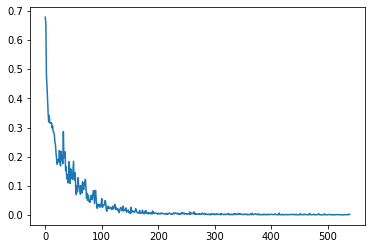

In [19]:
from src.trainer import Trainer
from src.model import CNN_TC

device = 'cuda:0'

model = CNN_TC('static', dataset, embed_mat, [3,4,5], 100, \
    dropout_ratio= .5, init=['he', None], bias=True, device=device).to(device)
criterion = nn.CrossEntropyLoss(weight=1 / torch.bincount(dataset['train_label']).to(torch.float).to(device))

optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=.95, weight_decay=1e-8)
#optimizer = torch.optim.SGD(model.parameters(), lr=2e-6, weight_decay=.7)

trainer = Trainer(model, criterion, optimizer, dataset, l2=9, device = device)

## score= when l2=3
trainer.train(30, show_batches=10)
trainer.test()
trainer.plot()

### Run All Model(of a Dataset)

In [24]:
from tqdm import tqdm
from src.model import CNN_TC
from src.trainer import Trainer
import torch.nn as nn
import torch
import numpy as np

device = 'cuda:0'
option = ['rand', 'static', 'nonstatic', 'multichannel'] # 'rand',
print(f"Tuning CNN in \"{data.upper()}\" set.")
for opt in option:
    
    model = CNN_TC(opt, dataset, embed_mat, [3,4,5], 100, \
    dropout_ratio= .5, init=[None, 'he'], bias=True, device=device).to(device)

    criterion = nn.CrossEntropyLoss()  # weight=len(data['train_label']) / torch.bincount(data['train_label']).to(torch.float)

    optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=.95, weight_decay=0)
    trainer = Trainer(model, criterion, optimizer, dataset, l2=9, device=device)

    lst = []
    timeiter = tqdm(range(30), position=0, leave=True)
    m = 0
    for i in timeiter:
        trainer.train(1, show_batches=50, verbose=False)
        l = trainer.test(verbose=False)
        lst.append(l)
        m = max(m, l)
        timeiter.set_description(f"Acc : {100*l:.2f}, Max : {100*m:.2f}")
    #trainer.plot()
    Len = np.argmax(lst)
    print(f"Best Score for {opt.upper()} was {100*m:.2f} at {Len}^th epoch")


Tuning CNN in "SST1" set.


Acc : 40.63, Max : 45.11: 100%|██████████| 30/30 [08:08<00:00, 16.27s/it]


Best Score for RAND was 45.11 at 2^th epoch


Acc : 41.49, Max : 46.29: 100%|██████████| 30/30 [04:00<00:00,  8.03s/it]


Best Score for STATIC was 46.29 at 7^th epoch


Acc : 40.68, Max : 48.87: 100%|██████████| 30/30 [08:07<00:00, 16.24s/it]


Best Score for NONSTATIC was 48.87 at 2^th epoch


Acc : 43.44, Max : 48.19: 100%|██████████| 30/30 [11:11<00:00, 22.37s/it]

Best Score for MULTICHANNEL was 48.19 at 0^th epoch


### TEST Result
Below are the entire score for all model, for all datasets.
I did not used Cross Validation check, so the score may not be stable.

|       Model|SST1 |SST2 | CR  | MR  |TREC|MPQA |SUBJ|
|---         |---  |---  |---  |---  |--- |---  | ---|
|Random      |45.11|84.84|79.89|75.26|91.6|85.49|90.7|
|Static      |46.29|86.27|85.98|79.94|93.4|89.92|92.9|
|Non-Static  |48.87|88.25|85.87|81.44|94.2|89.92|93.5|
|MultiChannel|48.19|87.92|87.30|81.26|93.6|89.54|93.3|